<hr style="height:5px;border-width:2;color:gray;background-color:#000000"> 
<center><h1>Frankengenome challenge</h1></center>
<br>

Dr. Frankenstein is trying to create a new species of bacterium by splicing together the genomes of bacteria $A$ and $B$. Unfortunately, he lost all but the first two pages of his notes describing how they were spliced together.  He needs your help to identify which parts of the frankengenome came from which bacterium.  You are given the full frankengenome called `frankengenome.fa` as well as the first two pages of notes, called `frankengenome_train.txt` and `frankengenome_test.txt`, which have correct labels for the first 50,000 and the next 50,000 bases of the frankengenome respectively. The label `0` indicates the base came from genome $A$ and the label `1` indicates it came from genome $B$.  E.g. the label `0000011111110011` indicates the first 5 bases came from genome $A$, the next 7 from genome $B$, the next 2 from genome $A$, and the last 2 from genome $B$. (Credits: Jacob Pritt)

The objective of this project is to implement a classifier that assigns a label to each base of the frankengenome according to whether it came from genome $A$ or $B$.  A good way to solve this problem is to use a hidden Markov model as we discussed in class.   While you may choose to experiment with higher-order HMM, a 1st order HMM -- where states correspond to genomes (A or B) and emissions to individual bases -- will do fine here.

You can either write your own code from scratch, or borrow freely from any HMM implementations like  <A HREF="http://nbviewer.ipython.org/github/BenLangmead/comp-genomics-class/blob/master/notebooks/CG_HMM.ipynb">this one</A> (but remember to acknowledge any code that you borrowed).
Using an HMM Python library like <A href="https://hmmlearn.readthedocs.io/en/latest/">hmmlearn</A> is not allowed because it would solve this problem with a few lines of code. In case you are in doubt, please ask.

When you build your classifier, train it using *only* the data from `frankengenome_train.txt`.  When you test your classifier to assess accuracy, test it using *only* the data from `frankengenome_test.txt`.  This will give you a more accurate picture about how your classifier performs on the whole genome than if you build and test using the same data. You are not expected to get the labels 100% correct, but try to get at least 95% accuracy on the test data (accuracy is measured as the fraction of genome positions that are classified correctly).

First let's get the frankengenome in FASTA format.

In [103]:
!wget http://www.cs.ucr.edu/~stelo/cs144spring21/data/frankengenome.fa

--2021-06-06 12:52:51--  http://www.cs.ucr.edu/~stelo/cs144spring21/data/frankengenome.fa
Resolving www.cs.ucr.edu (www.cs.ucr.edu)... 169.235.30.15
Connecting to www.cs.ucr.edu (www.cs.ucr.edu)|169.235.30.15|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1671394 (1.6M)
Saving to: ‘frankengenome.fa.1’

frankengenome.fa.1  100%[===================>]   1.59M  --.-KB/s    in 0.03s   

2021-06-06 12:52:51 (58.4 MB/s) - ‘frankengenome.fa.1’ saved [1671394/1671394]



Let's take a quick look

In [104]:
!head frankengenome.fa

>Frankengenome 1
GCTGCATAGAGGGACCAAGAGCAATCAAGGCCCAGAACCAAGGCCCAGCTCGATGTTGGC
AACAACACCCGTCCACTTGACAGGTGTACCGATAGGTGTTTACACCTGTCATGGCAGCTA
TTGGTCGGCGTTGGATGGCCGTTGCCGAGCGCTAGGAGCACAACTTTTGTGGGCCAAGTT
CAACAGGCCCGGCGATCAGCTAGGCGGTAGGAGCGAACTAACAGCTCACGGCAAAGGTGC
GACTTTGCCGCACTATTGATGTGGCGGGCTTCGATTGTCAAAAGGCATGCCGACGGTTGG
CAACAAAACGCAACACCACCCAAGAAACACTCACACCGCCAGAGCCCACATGCCTACCAC


TCGTCGAATCGCCCGTTTGTGTTGTTCGTTTATTTTGGCTATTTCGTACCCTAAACCGCC


Now we get the training data, which are the labels for the first 50,000 bases of the frankengenome

In [105]:
!wget http://www.cs.ucr.edu/~stelo/cs144spring21/data/frankengenome_train.txt

--2021-06-06 12:52:51--  http://www.cs.ucr.edu/~stelo/cs144spring21/data/frankengenome_train.txt
Resolving www.cs.ucr.edu (www.cs.ucr.edu)... 169.235.30.15
Connecting to www.cs.ucr.edu (www.cs.ucr.edu)|169.235.30.15|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50001 (49K) [text/plain]
Saving to: ‘frankengenome_train.txt.1’

frankengenome_train 100%[===================>]  48.83K  --.-KB/s    in 0s      

2021-06-06 12:52:52 (141 MB/s) - ‘frankengenome_train.txt.1’ saved [50001/50001]



Finally we get the test data, which are the labels for the next 50,000 bases of the frankengenome

In [106]:
!wget http://www.cs.ucr.edu/~stelo/cs144spring21/data/frankengenome_test.txt

--2021-06-06 12:52:52--  http://www.cs.ucr.edu/~stelo/cs144spring21/data/frankengenome_test.txt
Resolving www.cs.ucr.edu (www.cs.ucr.edu)... 169.235.30.15
Connecting to www.cs.ucr.edu (www.cs.ucr.edu)|169.235.30.15|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50001 (49K) [text/plain]
Saving to: ‘frankengenome_test.txt.1’

frankengenome_test. 100%[===================>]  48.83K  --.-KB/s    in 0s      

2021-06-06 12:52:52 (134 MB/s) - ‘frankengenome_test.txt.1’ saved [50001/50001]



Provide the code below, and your accuracy results on the test set. Collect some experimental data on the time required by your algorithm for longer and longer prefixes of the frankengenome to understand what is the experimental time complexity of your implementation.

In [110]:
## HMM scratch implementation code provided by https://nbviewer.jupyter.org/github/BenLangmead/comp-genomics-class/blob/master/notebooks/CG_HMM.ipynb##

import math
import numpy

class HMM(object):
    ''' Simple Hidden Markov Model implementation.  User provides
        transition, emission and initial probabilities in dictionaries
        mapping 2-character codes onto floating-point probabilities
        for those table entries.  States and emissions are represented
        with single characters.  Emission symbols comes from a finite.  '''
    
    def __init__(self, A, E, I):
        ''' Initialize the HMM given transition, emission and initial
            probability tables. '''
        
        # put state labels to the set self.Q
        self.Q, self.S = set(), set() # states and symbols
        for a, prob in A.items():
            asrc, adst = a[0], a[1]
            self.Q.add(asrc)
            self.Q.add(adst)
        # add all the symbols to the set self.S
        for e, prob in E.items():
            eq, es = e[0], e[1]
            self.Q.add(eq)
            self.S.add(es)
        
        self.Q = sorted(list(self.Q))
        self.S = sorted(list(self.S))
        
        # create maps from state labels / emission symbols to integers
        # that function as unique IDs
        qmap, smap = {}, {}
        for i in range(len(self.Q)): qmap[self.Q[i]] = i
        for i in range(len(self.S)): smap[self.S[i]] = i
        lenq = len(self.Q)
        
        # create and populate transition probability matrix
        self.A = numpy.zeros(shape=(lenq, lenq), dtype=float)
        for a, prob in A.items():
            asrc, adst = a[0], a[1]
            self.A[qmap[asrc], qmap[adst]] = prob
        # make A stochastic (i.e. make rows add to 1)
        self.A /= self.A.sum(axis=1)[:, numpy.newaxis]
        
        # create and populate emission probability matrix
        self.E = numpy.zeros(shape=(lenq, len(self.S)), dtype=float)
        for e, prob in E.items():
            eq, es = e[0], e[1]
            self.E[qmap[eq], smap[es]] = prob
        # make E stochastic (i.e. make rows add to 1)
        self.E /= self.E.sum(axis=1)[:, numpy.newaxis]
        
        # initial probabilities
        self.I = [ 0.0 ] * len(self.Q)
        for a, prob in I.items():
            self.I[qmap[a]] = prob
        # make I stochastic (i.e. adds to 1)
        self.I = numpy.divide(self.I, sum(self.I))
        
        self.qmap, self.smap = qmap, smap
        
        # Make log-base-2 versions for log-space functions
        self.Alog = numpy.log2(self.A)
        self.Elog = numpy.log2(self.E)
        self.Ilog = numpy.log2(self.I)
    

    def jointProb(self, p, x):
        ''' Return joint probability of path p and emission string x '''
        p = list(map(self.qmap.get, p)) # turn state characters into ids
        x = list(map(self.smap.get, x)) # turn emission characters into ids
        tot = self.I[p[0]] # start with initial probability
        for i in range(1, len(p)):
            tot *= self.A[p[i-1], p[i]] # transition probability
        for i in range(0, len(p)):
            tot *= self.E[p[i], x[i]] # emission probability
        return tot
    
    def jointProbL(self, p, x):
        ''' Return log2 of joint probability of path p and emission
            string x.  Just like self.jointProb(...) but log2 domain. '''
        p = list(map(self.qmap.get, p)) # turn state characters into ids
        x = list(map(self.smap.get, x)) # turn emission characters into ids
        tot = self.Ilog[p[0]] # start with initial probability
        for i in range(1, len(p)):
            tot += self.Alog[p[i-1], p[i]] # transition probability
        for i in range(0, len(p)):
            tot += self.Elog[p[i], x[i]] # emission probability
        return tot
    
    def viterbi(self, x):
        ''' Given sequence of emissions, return the most probable path
            along with its probability. '''
        x = list(map(self.smap.get, x)) # turn emission characters into ids
        nrow, ncol = len(self.Q), len(x)
        mat   = numpy.zeros(shape=(nrow, ncol), dtype=float) # prob
        matTb = numpy.zeros(shape=(nrow, ncol), dtype=int)   # backtrace
        # Fill in first column
        for i in range(0, nrow):
            mat[i, 0] = self.E[i, x[0]] * self.I[i]
        # Fill in rest of prob and Tb tables
        for j in range(1, ncol):
            for i in range(0, nrow):
                ep = self.E[i, x[j]]
                mx, mxi = mat[0, j-1] * self.A[0, i] * ep, 0
                for i2 in range(1, nrow):
                    pr = mat[i2, j-1] * self.A[i2, i] * ep
                    if pr > mx:
                        mx, mxi = pr, i2
                mat[i, j], matTb[i, j] = mx, mxi
        # Find final state with maximal probability
        omx, omxi = mat[0, ncol-1], 0
        for i in range(1, nrow):
            if mat[i, ncol-1] > omx:
                omx, omxi = mat[i, ncol-1], i
        # Backtrace
        i, p = omxi, [omxi]
        for j in range(ncol-1, 0, -1):
            i = matTb[i, j]
            p.append(i)
        p = ''.join(map(lambda x: self.Q[x], p[::-1]))
        return omx, p # Return probability and path
    
    def viterbiL(self, x):
        ''' Given sequence of emissions, return the most probable path
            along with log2 of its probability.  Just like viterbi(...)
            but in log2 domain. '''
        x = list(map(self.smap.get, x)) # turn emission characters into ids
        nrow, ncol = len(self.Q), len(x)
        mat   = numpy.zeros(shape=(nrow, ncol), dtype=float) # prob
        matTb = numpy.zeros(shape=(nrow, ncol), dtype=int)   # backtrace
        # Fill in first column
        for i in range(0, nrow):
            mat[i, 0] = self.Elog[i, x[0]] + self.Ilog[i]
        # Fill in rest of log prob and Tb tables
        for j in range(1, ncol):
            for i in range(0, nrow):
                ep = self.Elog[i, x[j]]
                mx, mxi = mat[0, j-1] + self.Alog[0, i] + ep, 0
                for i2 in range(1, nrow):
                    pr = mat[i2, j-1] + self.Alog[i2, i] + ep
                    if pr > mx:
                        mx, mxi = pr, i2
                mat[i, j], matTb[i, j] = mx, mxi
        # Find final state with maximal log probability
        omx, omxi = mat[0, ncol-1], 0
        for i in range(1, nrow):
            if mat[i, ncol-1] > omx:
                omx, omxi = mat[i, ncol-1], i
        # Backtrace
        i, p = omxi, [omxi]
        for j in range(ncol-1, 0, -1):
            i = matTb[i, j]
            p.append(i)
        p = ''.join(map(lambda x: self.Q[x], p[::-1]))
        return omx, p # Return log probability and path
    
###########################Code provided by https://nbviewer.jupyter.org/github/BenLangmead/comp-genomics-class/blob/master/notebooks/CG_HMM.ipynb ###############################################

In [280]:
import pandas as pd
def myFunc(value):
    fFile=open("frankengenome.fa",'r')
    fFirstLine=fFile.readline()
    fF = fFile.read()
    fFile.close()
    fList=list(fF)
    fList = [x for x in fList if x != '\n']
    fList = fList[:50000]
    tFile=open("frankengenome_train.txt",'r')
    tF = tFile.read()
    tFile.close()
    tList=list(tF)
    tList=tList[:value]
    tList = [x for x in tList if x != '\n']
    eList=[j for i in zip(tList,fList) for j in i]
    ######################## https://stackoverflow.com/questions/47297585/building-a-transition-matrix-using-words-in-python-numpy
    transMatrix=pd.crosstab(pd.Series(tList[1:],name='Next'), ##Forward probability that next number is 1 given that previous number is 0 can be found at column "0", row "1" 
                    pd.Series(tList[:-1],name='Previous'),normalize=1)
    emisMatrix=pd.crosstab(pd.Series(eList[1:],name='Next'), ##Forward probability that next letter is A given that previous number is 0 can be found at column "0", row "1" 
                    pd.Series(eList[:-1],name='Previous'),normalize=1)
    #print(transMatrix)
    #print(emisMatrix)
    ######################## https://stackoverflow.com/questions/47297585/building-a-transition-matrix-using-words-in-python-numpy
    l = transMatrix.values  # 1,0 are the states
                                      # A,T,G,C are the emissions
    n = emisMatrix.values

    tDict={"00":l[0][0], "01":l[0][1], "10":l[1][0], "11":l[1][1]}
    eDict={"0A":n[0][2],"0C":n[0][3],"0T":n[0][5],"0G":n[0][4],
           "1A":n[1][2],"1C":n[1][3],"1T":n[1][5],"1G":n[1][4]}  #Potential errors here
    iDict={'0':0.5, '1':0.5}
    #print(tDict)
    #print(eDict)
    hmm=HMM(tDict, #Transition Matrix A
            eDict, # Emission Matrix B
            iDict) # Initial Probalities I

    testFile=open("frankengenome.fa",'r')
    testFirstLine=testFile.readline()
    testF = testFile.read()
    testFile.close()
    testList=list(testF)
    testList = [x for x in testList if x != '\n']
    testList = testList[50000:100000]
    new=str()
    for x in testList:
        new += x 
    logP, path= hmm.viterbiL(new)

    newFile=open("frankengenome_test.txt",'r')
    newF = newFile.read()
    newFile.close()
    newList=list(newF)
    newList = [x for x in newList if x != '\n']
    new1=str()
    for x in newList:
        new1 += x 

    result=0
    #print(len(new1),len(path))
    for i in range(len(new1)):
        if path[i]==new1[i]:
            result+=1
    return(result/len(new1)*100)
i=1461
accuracyList=list()
testList=list()
while i<50000:
    accuracyList.append(myFunc(i))
    testList.append(i)
    i+=1000
print(sum(accuracyList)/len(accuracyList))

97.49285714285712


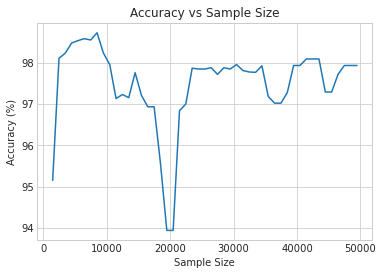

In [284]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np



fig = plt.figure()
ax = plt.axes()

plt.plot(testList,myValues)
plt.title("Accuracy vs Sample Size")
plt.xlabel("Sample Size")
plt.ylabel("Accuracy (%)");